In [8]:
import os
import json
import requests
import numpy as np
import excursion.utils as utils
import excursion.optimize as optimize
import excursion.plotting.twodim as plots

from excursion import get_gp
np.warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
blackbox = lambda X: requests.get('http://gateway.openfaas.svc.cluster.local:8080/function/blackboxfunc', data = json.dumps({"X": X.tolist()})).json()

class scan(object):
    def __init__(self, functions):
        self.truth_functions = functions
        self.plot_rangedef = np.asarray([[0,1.5,101],[0,1.5,101]])
        self.plotG = utils.mgrid(self.plot_rangedef)
        self.plotX = utils.mesh2points(self.plotG,self.plot_rangedef[:,2])

        self.acq_rangedef = np.asarray([[0,1.5,21],[0,1.5,21]])
        self.acqG = utils.mgrid(self.acq_rangedef)
        self.acqX = utils.mesh2points(self.acqG,self.acq_rangedef[:,2])

        self.mean_rangedef = np.asarray([[0,1.5,21],[0,1.5,21]])
        self.meanG = utils.mgrid(self.mean_rangedef)
        self.meanX = utils.mesh2points(self.meanG,self.mean_rangedef[:,2])
        
        self.thresholds = [0.0]
    def invalid_region(self,X):
        return np.zeros(X.shape[0], dtype = 'bool')

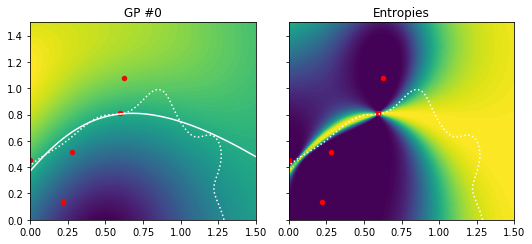

Iteration 1. new x: [[1.2   0.75 ]
 [1.05  0.225]]
Iteration 1. Evaluted function 0 to values: [0.9147674052167694, -0.8119970814612172]


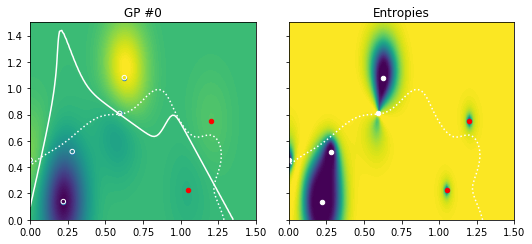

Iteration 2. new x: [[0.975 0.75 ]
 [0.375 1.05 ]]
Iteration 2. Evaluted function 0 to values: [-0.4678979650309678, 8.45585288058609]


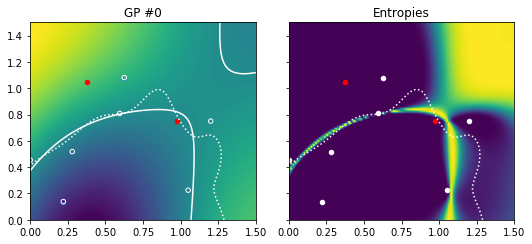

Iteration 3. new x: [[1.275 1.125]
 [1.35  0.3  ]]
Iteration 3. Evaluted function 0 to values: [2.3955523049572887, 2.662105296510776]


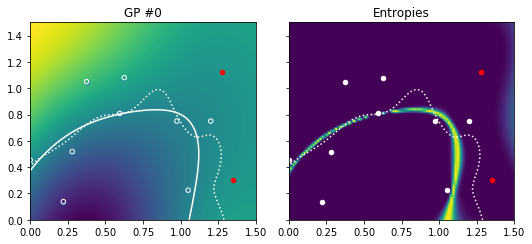

Iteration 4. new x: [[1.125 0.6  ]
 [1.35  0.75 ]]
Iteration 4. Evaluted function 0 to values: [-0.22936822956194236, 3.2979848652108403]


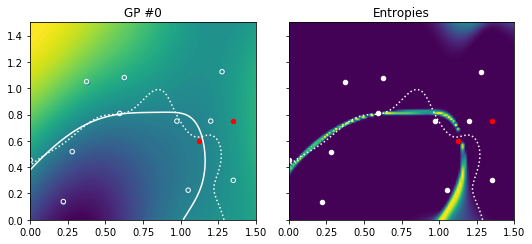

Iteration 5. new x: [[1.125 0.075]
 [1.125 1.425]]
Iteration 5. Evaluted function 0 to values: [-0.8953167548912124, 6.31505113594958]


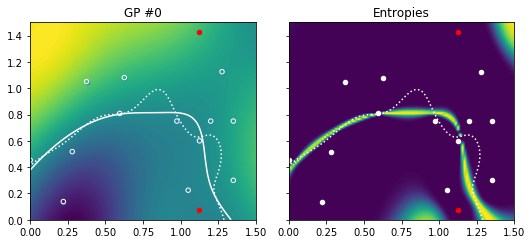

Iteration 6. new x: [[0.9   0.075]
 [0.975 0.075]]
Iteration 6. Evaluted function 0 to values: [-6.160223155780038, -3.5372457365231083]


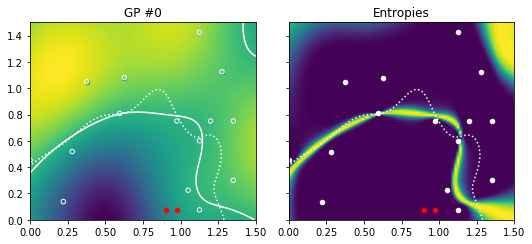

Iteration 7. new x: [[1.425 1.35 ]
 [1.425 0.075]]
Iteration 7. Evaluted function 0 to values: [6.42587472199173, 4.316938377961485]


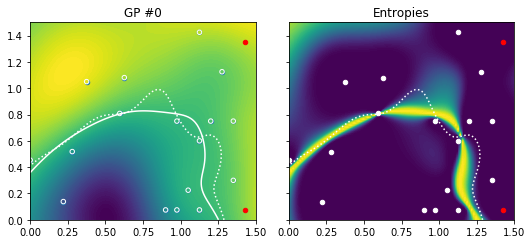

Iteration 8. new x: [[0.15  1.35 ]
 [0.975 0.825]]
Iteration 8. Evaluted function 0 to values: [8.987192156795256, 0.3064972182199126]


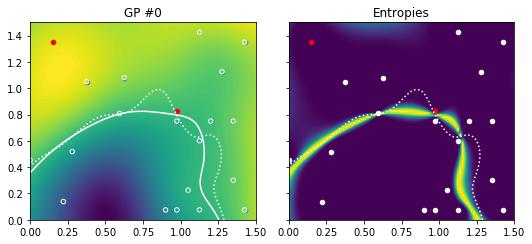

Iteration 9. new x: [[0.75  0.825]
 [0.6   1.425]]
Iteration 9. Evaluted function 0 to values: [-1.3405439439542843, 8.939141812398029]


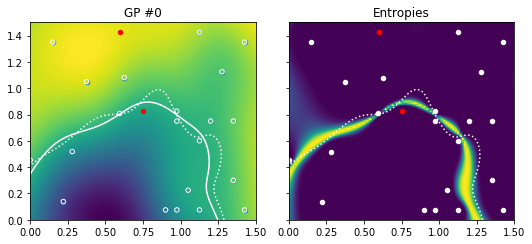

Iteration 10. new x: [[0.075 0.6  ]
 [1.2   0.375]]
Iteration 10. Evaluted function 0 to values: [5.503122009595197, -0.465757381513245]


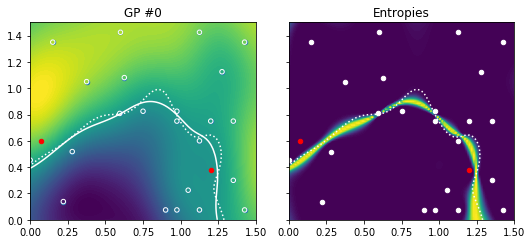

Iteration 11. new x: [[0.45  0.75 ]
 [0.225 0.525]]
Iteration 11. Evaluted function 0 to values: [-0.8883485388080863, -2.247200454088727]


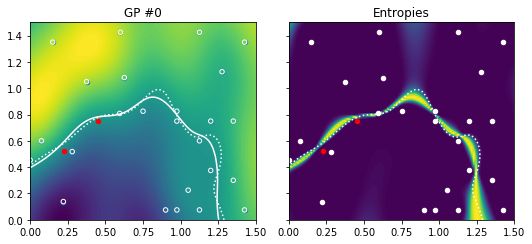

Iteration 12. new x: [[1.275 0.075]
 [1.2   0.45 ]]
Iteration 12. Evaluted function 0 to values: [0.1610083732865264, -0.6865136024489109]


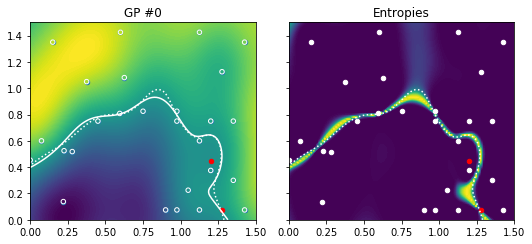

Iteration 13. new x: [[0.3   0.675]
 [0.825 1.05 ]]
Iteration 13. Evaluted function 0 to values: [0.8595589089027937, 0.9026708386703288]


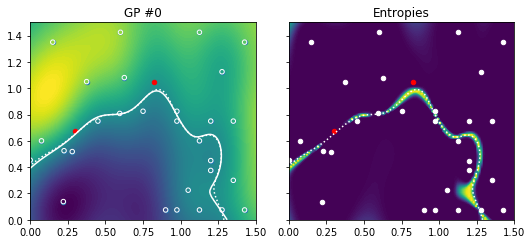

Iteration 14. new x: [[1.2   0.225]
 [0.825 0.975]]
Iteration 14. Evaluted function 0 to values: [-0.13275555786011983, -0.09865172427053448]


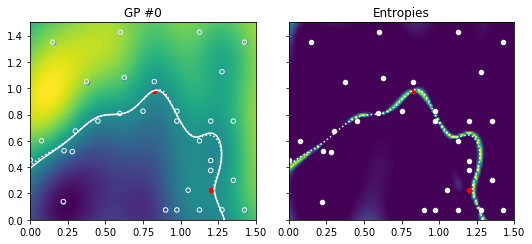

Iteration 15. new x: [[1.275 0.525]
 [0.525 0.15 ]]
Iteration 15. Evaluted function 0 to values: [0.1159963082116775, -10.996148886646372]


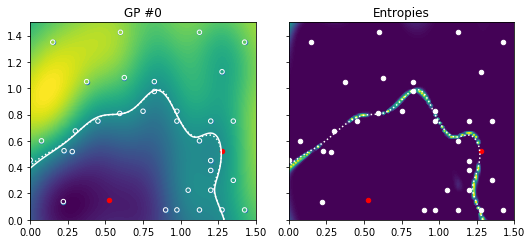

In [10]:
N_INIT  = 5
N_BATCH = 2
N_UPDATES = 15
scandetails = scan([blackbox])
X,y_list,gps = optimize.init(scandetails, seed = 1, n_init=N_INIT)


def show(*args,**kwargs):
    fig, axarr = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(7.5, 3.5)
    plots.plot(axarr,gps,X,y_list,scandetails, **kwargs)
    plt.tight_layout()
    plt.show()

show(gps,X,y_list,scandetails, batchsize = N_INIT)
for index in range(1,N_UPDATES+1):
    newx, acqvals = optimize.gridsearch(gps, X, scandetails, batchsize=N_BATCH)

    print('Iteration {}. new x: {}'.format(index, newx))
    newys_list = [func(newx) for func in scandetails.truth_functions]
    for i,newys in enumerate(newys_list):
        print('Iteration {}. Evaluted function {} to values: {}'.format(index, i,newys))
        y_list[i] = np.concatenate([y_list[i],newys])
    X = np.concatenate([X,newx])
    
    gps = [get_gp(X,y_list[i]) for i in range(len(scandetails.truth_functions))]
    show(gps,X,y_list,scandetails, batchsize=N_BATCH)
